# GAN Project
## Liz Parker, Colin Craighead, and Aren Dalloul

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras import models
from tensorflow.keras import utils
import tensorflow.keras.preprocessing.image as img
import scipy.io
from PIL import Image
import xml.etree.ElementTree as ET 

In [2]:
#test_mat = scipy.io.loadmat("data/test_data.mat")
train_mat = scipy.io.loadmat("data/train_data.mat")

In [3]:
def unpack_mat(mat, train_or_test):
    df = pd.DataFrame()
    paths = []
    crops = []
    num_datapoints = len(mat[train_or_test][0][0][0])
    for i in range(num_datapoints):
        path = "images/" + mat[train_or_test][0][0][0][i][0][0]
        paths.append(path)
        ano_path = "Annotation/" + mat[train_or_test]['annotation_list'][0][0][i][0][0]
        tree = ET.parse(ano_path)
        root = tree.getroot()
        objects = root.findall('object')
        for o in objects:
            bndbox = o.find('bndbox') 
            xmin = int(bndbox.find('xmin').text)
            ymin = int(bndbox.find('ymin').text)
            xmax = int(bndbox.find('xmax').text)
            ymax = int(bndbox.find('ymax').text)
            w = np.min((xmax - xmin, ymax - ymin))
            crop = (xmin, ymin, xmin+w, ymin+w)
        crops.append(crop)
    df['path'] = paths
    df['crops'] = crops
    return df

In [4]:
train_df = unpack_mat(train_mat, 'train_info')
# test_df = unpack_mat(test_mat, 'test_info')
train_df.head()

# #TO REMOVE !!!!!!!!!!!!!
# train_df = train_df.truncate(after = 1000)
train_df = train_df.sample(frac=.5)

In [5]:
train_df

,path,crops
7621,images/n02105412-kelpie/n02105412_6120.jpg,"(134, 57, 304, 227)"
9686,images/n02109525-Saint_Bernard/n02109525_243.jpg,"(167, 0, 327, 160)"
3714,images/n02095314-wire-haired_fox_terrier/n0209...,"(0, 0, 169, 169)"
6049,images/n02100583-vizsla/n02100583_11231.jpg,"(146, 74, 403, 331)"
9373,images/n02108551-Tibetan_mastiff/n02108551_734...,"(53, 16, 206, 169)"
...,...,...
1865,images/n02090622-borzoi/n02090622_8814.jpg,"(202, 48, 401, 247)"
6676,images/n02102040-English_springer/n02102040_68...,"(2, 10, 392, 400)"
220,images/n02085936-Maltese_dog/n02085936_5596.jpg,"(121, 6, 455, 340)"
9149,images/n02108089-boxer/n02108089_6418.jpg,"(0, 11, 215, 226)"


In [6]:
X_train = np.array([img.img_to_array(Image.open(row['path']).crop(row['crops']).resize((64,64))) for index, row in train_df.iterrows()])

In [7]:
X_train.shape

(6000, 64, 64, 3)

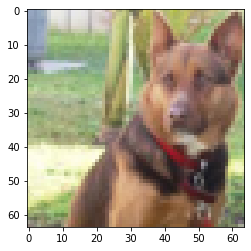

In [8]:
plt.imshow(tf.keras.preprocessing.image.array_to_img(X_train[0]))

In [9]:
X_train = X_train[:,:,:]/255

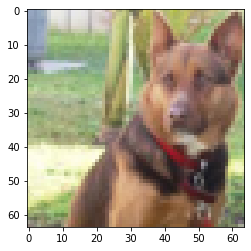

In [10]:
plt.imshow(X_train[0])

In [11]:
X_train.shape

(6000, 64, 64, 3)

In [12]:
def shift_negone_one(x):
    return x*2 - 1

In [13]:
def shift_zero_one(x):
    return (x+1)/2

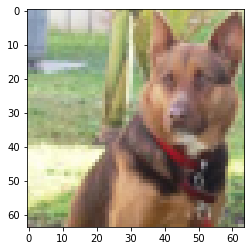

In [14]:
X_train = shift_negone_one(X_train[:,:,:])
plt.imshow(shift_zero_one(X_train[0]))

In [15]:
# define the standalone discriminator model
def define_discriminator(in_shape=(64,64,3)):
    model = tf.keras.models.Sequential()
    model.add(tf.keras.layers.Conv2D(32, (4,4), strides=(2, 2), padding='same', input_shape=in_shape))
    model.add(tf.keras.layers.LeakyReLU(alpha=0.2))
    model.add(layers.BatchNormalization())
    model.add(tf.keras.layers.Conv2D(32, (4,4), strides=(2, 2), padding='same'))
    model.add(tf.keras.layers.LeakyReLU(alpha=0.2))
    model.add(layers.BatchNormalization())
    model.add(tf.keras.layers.Conv2D(64, (4,4), strides=(2, 2), padding='same'))
    model.add(tf.keras.layers.LeakyReLU(alpha=0.2))
    model.add(layers.BatchNormalization())
    model.add(tf.keras.layers.Conv2D(64, (4,4), strides=(2, 2), padding='same'))
    model.add(tf.keras.layers.LeakyReLU(alpha=0.2))
    model.add(layers.BatchNormalization())
    model.add(tf.keras.layers.Flatten())
    model.add(tf.keras.layers.Dense(2, activation='sigmoid'))
    # compile model
    opt = tf.keras.optimizers.Adam(lr=0.0002, beta_1=0.5)
    model.compile(loss='binary_crossentropy', optimizer=opt, metrics=['accuracy'])
    return model

# define model
model_d = define_discriminator()
# summarize the model
model_d.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 32, 32, 32)        1568      
_________________________________________________________________
leaky_re_lu (LeakyReLU)      (None, 32, 32, 32)        0         
_________________________________________________________________
batch_normalization (BatchNo (None, 32, 32, 32)        128       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 16, 16, 32)        16416     
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 16, 16, 32)        0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 16, 16, 32)        128       
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 8, 8, 64)          3

In [16]:
def create_random_image(dim,num_samples):
    return shift_negone_one(np.random.rand(dim[0]*dim[1]*dim[2]*num_samples).reshape(num_samples,dim[0],dim[1],dim[2]))

In [17]:
num_fakes = 4000
X_fakes = create_random_image([64,64,3],num_fakes)

In [18]:
X_fakes.shape

(4000, 64, 64, 3)

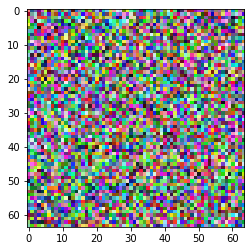

In [19]:
plt.imshow(shift_zero_one(X_fakes[0]))

In [20]:
y_fakes = np.tile([1.0,0.0],(num_fakes,1))
y_fakes.shape

(4000, 2)

In [21]:
y_train = np.tile([0.0,1.0],(X_train.shape[0],1))
y_train.shape

(6000, 2)

In [22]:
mix_y_train = np.append(y_train,y_fakes,axis=0)
mix_y_train.shape

(10000, 2)

In [23]:
mix_X_train = np.append(X_train,X_fakes,axis=0)
mix_X_train.shape

(10000, 64, 64, 3)

In [24]:
model_d.fit(mix_X_train,mix_y_train,epochs=1,shuffle=True,verbose=1)

Train on 10000 samples
10000/10000 [==============================] - 20s 2ms/sample - loss: 0.0289 - accuracy: 0.9888


In [25]:
latent_dim = 100

def define_generator(latent_dim):
    model = tf.keras.models.Sequential()
    # foundation for 8x8 image
    n_nodes = 512 * 4 * 4
    model.add(tf.keras.layers.Dense(n_nodes, input_dim=latent_dim))
    model.add(tf.keras.layers.LeakyReLU(alpha=0.2))
    model.add(tf.keras.layers.Reshape((4, 4, 512)))
    # upsample to 8x8
    model.add(tf.keras.layers.UpSampling2D())
    model.add(layers.Conv2D(256,(4,4),padding='same'))
    model.add(tf.keras.layers.LeakyReLU(alpha=0.2))
    model.add(layers.BatchNormalization())
    model.add(tf.keras.layers.LeakyReLU(alpha=0.2))
    # upsample to 16x16
    model.add(tf.keras.layers.UpSampling2D())
    model.add(layers.Conv2D(128,(4,4),padding='same'))
    model.add(tf.keras.layers.LeakyReLU(alpha=0.2))
    model.add(layers.BatchNormalization())
    model.add(tf.keras.layers.LeakyReLU(alpha=0.2))
    # upsample to 32x32
    model.add(tf.keras.layers.UpSampling2D())
    model.add(layers.Conv2D(64,(4,4),padding='same'))
    model.add(tf.keras.layers.LeakyReLU(alpha=0.2))
    model.add(layers.BatchNormalization())
    model.add(tf.keras.layers.LeakyReLU(alpha=0.2))
    # upsample to 64x64
    model.add(tf.keras.layers.UpSampling2D())
    model.add(layers.Conv2D(64,(4,4),padding='same'))
    model.add(tf.keras.layers.LeakyReLU(alpha=0.2))
    model.add(layers.BatchNormalization())
    model.add(tf.keras.layers.LeakyReLU(alpha=0.2))
    model.add(tf.keras.layers.Conv2D(3, (5,5), activation='tanh', padding='same'))
    return model
    
model_g = define_generator(latent_dim)
model_g.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 8192)              827392    
_________________________________________________________________
leaky_re_lu_4 (LeakyReLU)    (None, 8192)              0         
_________________________________________________________________
reshape (Reshape)            (None, 4, 4, 512)         0         
_________________________________________________________________
up_sampling2d (UpSampling2D) (None, 8, 8, 512)         0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 8, 8, 256)         2097408   
_________________________________________________________________
leaky_re_lu_5 (LeakyReLU)    (None, 8, 8, 256)         0         
_________________________________________________________________
batch_normalization_4 (Batch (None, 8, 8, 256)        

In [26]:
def generate_normal_noise_points(latent_dim, n_samples):
    points = np.random.randn(latent_dim * n_samples)
    return points.reshape(n_samples, latent_dim)

In [27]:
def generate_fake_images(model, latent_dim, n_samples):
    x_input = generate_normal_noise_points(latent_dim, n_samples)
    fake_images = model.predict(x_input)
    labels = np.tile([1.0,0.0],(n_samples,1))
    return fake_images, labels

In [28]:
test_image,_ =  generate_fake_images(model_g,latent_dim,1)
test_image.shape

(1, 64, 64, 3)

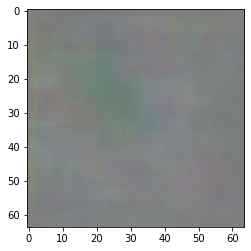

In [29]:
plt.imshow(shift_zero_one(test_image[0]))

In [30]:
def define_gan(g_model, d_model):
    d_model.trainable = False
    model = tf.keras.models.Sequential()
    model.add(g_model)
    model.add(d_model)
    opt = tf.keras.optimizers.Adam(lr=0.0002, beta_1=0.5)
    model.compile(loss='binary_crossentropy', optimizer=opt)
    return model

In [31]:
gan_model = define_gan(model_g, model_d)
gan_model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
sequential_1 (Sequential)    (None, 64, 64, 3)         3652803   
_________________________________________________________________
sequential (Sequential)      (None, 2)                 119234    
Total params: 3,772,037
Trainable params: 3,651,779
Non-trainable params: 120,258
_________________________________________________________________


In [32]:
def train(g_model, d_model, gan_model, real_images, latent_dim, n_epochs=12, n_batch=32):
    bat_per_epo = real_images.shape[0]//n_batch
    half_batch = n_batch//2
    for i in range(n_epochs):
        for j in range(bat_per_epo):
            X_real = real_images[np.random.randint(0,real_images.shape[0],half_batch)]
            y_real = np.tile([0.0,1.0],(half_batch,1))
            X_fake, y_fake = generate_fake_images(g_model, latent_dim, half_batch)
            d_loss, _ = d_model.train_on_batch(X_real, y_real)
            d_loss, _ = d_model.train_on_batch(X_fake, y_fake)
            
            X_gan = generate_normal_noise_points(latent_dim, n_batch)
            y_gan = np.tile([0.0,1.0],(n_batch,1))
            g_loss = gan_model.train_on_batch(X_gan, y_gan)
            
            print('>%d, %d/%d, d=%.3f, g=%.3f' % (i+1, j+1, bat_per_epo, d_loss, g_loss))
    return g_model, d_model, gan_model

In [33]:
final_g_model, final_d_model, final_gan_model = train(model_g, model_d, gan_model, X_train, latent_dim)

>1, 1/187, d=1.652, g=1.562
>1, 2/187, d=1.110, g=0.240
>1, 3/187, d=1.425, g=0.235
>1, 4/187, d=0.192, g=0.293
>1, 5/187, d=0.086, g=0.267
>1, 6/187, d=0.152, g=0.145
>1, 7/187, d=0.060, g=0.045
>1, 8/187, d=0.035, g=0.037
>1, 9/187, d=0.043, g=0.048
>1, 10/187, d=0.050, g=0.044
>1, 11/187, d=0.032, g=0.045
>1, 12/187, d=0.029, g=0.041
>1, 13/187, d=0.028, g=0.048
>1, 14/187, d=0.019, g=0.028
>1, 15/187, d=0.034, g=0.044
>1, 16/187, d=0.015, g=0.040
>1, 17/187, d=0.022, g=0.029
>1, 18/187, d=0.019, g=0.029
>1, 19/187, d=0.025, g=0.032
>1, 20/187, d=0.040, g=0.027
>1, 21/187, d=0.042, g=0.023
>1, 22/187, d=0.009, g=0.013
>1, 23/187, d=0.032, g=0.013
>1, 24/187, d=0.021, g=0.012
>1, 25/187, d=0.008, g=0.012
>1, 26/187, d=0.003, g=0.007
>1, 27/187, d=0.003, g=0.008
>1, 28/187, d=0.005, g=0.004
>1, 29/187, d=0.003, g=0.004
>1, 30/187, d=0.008, g=0.005
>1, 31/187, d=0.002, g=0.002
>1, 32/187, d=0.001, g=0.003
>1, 33/187, d=0.001, g=0.003
>1, 34/187, d=0.001, g=0.002
>1, 35/187, d=0.001, g=

>2, 95/187, d=0.001, g=0.000
>2, 96/187, d=0.000, g=0.000
>2, 97/187, d=0.000, g=0.001
>2, 98/187, d=0.000, g=0.000
>2, 99/187, d=0.000, g=0.000
>2, 100/187, d=0.000, g=0.000
>2, 101/187, d=0.001, g=0.000
>2, 102/187, d=0.001, g=0.000
>2, 103/187, d=0.001, g=0.000
>2, 104/187, d=0.001, g=0.000
>2, 105/187, d=0.000, g=0.001
>2, 106/187, d=0.000, g=0.000
>2, 107/187, d=0.000, g=0.000
>2, 108/187, d=0.000, g=0.000
>2, 109/187, d=0.000, g=0.000
>2, 110/187, d=0.000, g=0.000
>2, 111/187, d=0.000, g=0.000
>2, 112/187, d=0.000, g=0.000
>2, 113/187, d=0.000, g=0.000
>2, 114/187, d=0.000, g=0.000
>2, 115/187, d=0.001, g=0.000
>2, 116/187, d=0.001, g=0.000
>2, 117/187, d=0.000, g=0.000
>2, 118/187, d=0.001, g=0.000
>2, 119/187, d=0.001, g=0.000
>2, 120/187, d=0.001, g=0.000
>2, 121/187, d=0.000, g=0.000
>2, 122/187, d=0.000, g=0.000
>2, 123/187, d=0.000, g=0.000
>2, 124/187, d=0.001, g=0.000
>2, 125/187, d=0.001, g=0.000
>2, 126/187, d=0.000, g=0.000
>2, 127/187, d=0.001, g=0.000
>2, 128/187, d=

>3, 185/187, d=0.002, g=0.011
>3, 186/187, d=0.001, g=0.009
>3, 187/187, d=0.001, g=0.009
>4, 1/187, d=0.002, g=0.006
>4, 2/187, d=0.001, g=0.006
>4, 3/187, d=0.006, g=0.007
>4, 4/187, d=0.003, g=0.008
>4, 5/187, d=0.002, g=0.008
>4, 6/187, d=0.002, g=0.007
>4, 7/187, d=0.004, g=0.008
>4, 8/187, d=0.005, g=0.007
>4, 9/187, d=0.002, g=0.007
>4, 10/187, d=0.001, g=0.007
>4, 11/187, d=0.004, g=0.010
>4, 12/187, d=0.002, g=0.008
>4, 13/187, d=0.006, g=0.005
>4, 14/187, d=0.004, g=0.006
>4, 15/187, d=0.004, g=0.004
>4, 16/187, d=0.004, g=0.005
>4, 17/187, d=0.002, g=0.005
>4, 18/187, d=0.002, g=0.004
>4, 19/187, d=0.001, g=0.005
>4, 20/187, d=0.003, g=0.004
>4, 21/187, d=0.001, g=0.004
>4, 22/187, d=0.001, g=0.004
>4, 23/187, d=0.003, g=0.003
>4, 24/187, d=0.002, g=0.004
>4, 25/187, d=0.002, g=0.004
>4, 26/187, d=0.002, g=0.003
>4, 27/187, d=0.003, g=0.004
>4, 28/187, d=0.003, g=0.004
>4, 29/187, d=0.001, g=0.003
>4, 30/187, d=0.001, g=0.003
>4, 31/187, d=0.003, g=0.003
>4, 32/187, d=0.001,

>5, 91/187, d=0.000, g=0.001
>5, 92/187, d=0.000, g=0.001
>5, 93/187, d=0.000, g=0.001
>5, 94/187, d=0.000, g=0.001
>5, 95/187, d=0.000, g=0.001
>5, 96/187, d=0.000, g=0.001
>5, 97/187, d=0.000, g=0.001
>5, 98/187, d=0.000, g=0.001
>5, 99/187, d=0.000, g=0.001
>5, 100/187, d=0.000, g=0.001
>5, 101/187, d=0.000, g=0.001
>5, 102/187, d=0.000, g=0.001
>5, 103/187, d=0.000, g=0.001
>5, 104/187, d=0.000, g=0.001
>5, 105/187, d=0.000, g=0.001
>5, 106/187, d=0.000, g=0.001
>5, 107/187, d=0.000, g=0.001
>5, 108/187, d=0.000, g=0.001
>5, 109/187, d=0.000, g=0.001
>5, 110/187, d=0.000, g=0.001
>5, 111/187, d=0.000, g=0.001
>5, 112/187, d=0.000, g=0.001
>5, 113/187, d=0.000, g=0.001
>5, 114/187, d=0.000, g=0.001
>5, 115/187, d=0.000, g=0.001
>5, 116/187, d=0.000, g=0.001
>5, 117/187, d=0.000, g=0.001
>5, 118/187, d=0.000, g=0.001
>5, 119/187, d=0.000, g=0.001
>5, 120/187, d=0.000, g=0.001
>5, 121/187, d=0.000, g=0.001
>5, 122/187, d=0.000, g=0.001
>5, 123/187, d=0.000, g=0.001
>5, 124/187, d=0.00

>6, 181/187, d=0.000, g=0.001
>6, 182/187, d=0.000, g=0.001
>6, 183/187, d=0.000, g=0.001
>6, 184/187, d=0.000, g=0.001
>6, 185/187, d=0.000, g=0.001
>6, 186/187, d=0.000, g=0.001
>6, 187/187, d=0.000, g=0.001
>7, 1/187, d=0.000, g=0.001
>7, 2/187, d=0.000, g=0.001
>7, 3/187, d=0.000, g=0.001
>7, 4/187, d=0.000, g=0.001
>7, 5/187, d=0.000, g=0.000
>7, 6/187, d=0.000, g=0.001
>7, 7/187, d=0.000, g=0.000
>7, 8/187, d=0.000, g=0.001
>7, 9/187, d=0.000, g=0.001
>7, 10/187, d=0.000, g=0.001
>7, 11/187, d=0.000, g=0.001
>7, 12/187, d=0.000, g=0.001
>7, 13/187, d=0.000, g=0.001
>7, 14/187, d=0.000, g=0.001
>7, 15/187, d=0.000, g=0.000
>7, 16/187, d=0.000, g=0.000
>7, 17/187, d=0.000, g=0.001
>7, 18/187, d=0.000, g=0.001
>7, 19/187, d=0.000, g=0.001
>7, 20/187, d=0.000, g=0.001
>7, 21/187, d=0.000, g=0.001
>7, 22/187, d=0.000, g=0.001
>7, 23/187, d=0.000, g=0.001
>7, 24/187, d=0.000, g=0.001
>7, 25/187, d=0.000, g=0.001
>7, 26/187, d=0.000, g=0.000
>7, 27/187, d=0.000, g=0.001
>7, 28/187, d=0.

>8, 87/187, d=0.000, g=0.000
>8, 88/187, d=0.000, g=0.000
>8, 89/187, d=0.000, g=0.000
>8, 90/187, d=0.000, g=0.000
>8, 91/187, d=0.000, g=0.000
>8, 92/187, d=0.000, g=0.000
>8, 93/187, d=0.000, g=0.000
>8, 94/187, d=0.000, g=0.000
>8, 95/187, d=0.000, g=0.000
>8, 96/187, d=0.000, g=0.000
>8, 97/187, d=0.000, g=0.000
>8, 98/187, d=0.000, g=0.000
>8, 99/187, d=0.000, g=0.000
>8, 100/187, d=0.000, g=0.000
>8, 101/187, d=0.000, g=0.000
>8, 102/187, d=0.000, g=0.000
>8, 103/187, d=0.000, g=0.000
>8, 104/187, d=0.000, g=0.000
>8, 105/187, d=0.000, g=0.000
>8, 106/187, d=0.000, g=0.000
>8, 107/187, d=0.000, g=0.000
>8, 108/187, d=0.000, g=0.000
>8, 109/187, d=0.000, g=0.000
>8, 110/187, d=0.000, g=0.000
>8, 111/187, d=0.000, g=0.000
>8, 112/187, d=0.000, g=0.000
>8, 113/187, d=0.000, g=0.000
>8, 114/187, d=0.000, g=0.000
>8, 115/187, d=0.000, g=0.000
>8, 116/187, d=0.000, g=0.000
>8, 117/187, d=0.000, g=0.000
>8, 118/187, d=0.000, g=0.000
>8, 119/187, d=0.000, g=0.000
>8, 120/187, d=0.000, g

>9, 178/187, d=0.000, g=0.000
>9, 179/187, d=0.000, g=0.000
>9, 180/187, d=0.000, g=0.000
>9, 181/187, d=0.000, g=0.000
>9, 182/187, d=0.000, g=0.000
>9, 183/187, d=0.000, g=0.000
>9, 184/187, d=0.000, g=0.000
>9, 185/187, d=0.000, g=0.000
>9, 186/187, d=0.000, g=0.000
>9, 187/187, d=0.000, g=0.000
>10, 1/187, d=0.000, g=0.000
>10, 2/187, d=0.000, g=0.000
>10, 3/187, d=0.000, g=0.000
>10, 4/187, d=0.000, g=0.000
>10, 5/187, d=0.000, g=0.000
>10, 6/187, d=0.000, g=0.000
>10, 7/187, d=0.000, g=0.000
>10, 8/187, d=0.000, g=0.000
>10, 9/187, d=0.000, g=0.000
>10, 10/187, d=0.000, g=0.000
>10, 11/187, d=0.000, g=0.000
>10, 12/187, d=0.000, g=0.000
>10, 13/187, d=0.000, g=0.000
>10, 14/187, d=0.000, g=0.000
>10, 15/187, d=0.000, g=0.000
>10, 16/187, d=0.000, g=0.000
>10, 17/187, d=0.000, g=0.000
>10, 18/187, d=0.000, g=0.000
>10, 19/187, d=0.000, g=0.000
>10, 20/187, d=0.000, g=0.000
>10, 21/187, d=0.000, g=0.000
>10, 22/187, d=0.000, g=0.000
>10, 23/187, d=0.000, g=0.000
>10, 24/187, d=0.00

>11, 75/187, d=0.000, g=0.000
>11, 76/187, d=0.000, g=0.000
>11, 77/187, d=0.000, g=0.000
>11, 78/187, d=0.000, g=0.000
>11, 79/187, d=0.000, g=0.000
>11, 80/187, d=0.000, g=0.000
>11, 81/187, d=0.000, g=0.000
>11, 82/187, d=0.000, g=0.000
>11, 83/187, d=0.000, g=0.000
>11, 84/187, d=0.000, g=0.000
>11, 85/187, d=0.000, g=0.000
>11, 86/187, d=0.000, g=0.000
>11, 87/187, d=0.000, g=0.000
>11, 88/187, d=0.000, g=0.000
>11, 89/187, d=0.000, g=0.000
>11, 90/187, d=0.000, g=0.000
>11, 91/187, d=0.000, g=0.000
>11, 92/187, d=0.000, g=0.000
>11, 93/187, d=0.000, g=0.000
>11, 94/187, d=0.000, g=0.000
>11, 95/187, d=0.000, g=0.000
>11, 96/187, d=0.000, g=0.000
>11, 97/187, d=0.000, g=0.000
>11, 98/187, d=0.000, g=0.000
>11, 99/187, d=0.000, g=0.000
>11, 100/187, d=0.000, g=0.000
>11, 101/187, d=0.000, g=0.000
>11, 102/187, d=0.000, g=0.000
>11, 103/187, d=0.000, g=0.000
>11, 104/187, d=0.000, g=0.000
>11, 105/187, d=0.000, g=0.000
>11, 106/187, d=0.000, g=0.000
>11, 107/187, d=0.000, g=0.000
>1

>12, 157/187, d=0.000, g=0.000
>12, 158/187, d=0.000, g=0.000
>12, 159/187, d=0.000, g=0.000
>12, 160/187, d=0.000, g=0.000
>12, 161/187, d=0.000, g=0.000
>12, 162/187, d=0.000, g=0.000
>12, 163/187, d=0.000, g=0.000
>12, 164/187, d=0.000, g=0.000
>12, 165/187, d=0.000, g=0.000
>12, 166/187, d=0.000, g=0.000
>12, 167/187, d=0.000, g=0.000
>12, 168/187, d=0.000, g=0.000
>12, 169/187, d=0.000, g=0.000
>12, 170/187, d=0.000, g=0.000
>12, 171/187, d=0.000, g=0.000
>12, 172/187, d=0.000, g=0.000
>12, 173/187, d=0.000, g=0.000
>12, 174/187, d=0.000, g=0.000
>12, 175/187, d=0.000, g=0.000
>12, 176/187, d=0.000, g=0.000
>12, 177/187, d=0.000, g=0.000
>12, 178/187, d=0.000, g=0.000
>12, 179/187, d=0.000, g=0.000
>12, 180/187, d=0.000, g=0.000
>12, 181/187, d=0.000, g=0.000
>12, 182/187, d=0.000, g=0.000
>12, 183/187, d=0.000, g=0.000
>12, 184/187, d=0.000, g=0.000
>12, 185/187, d=0.000, g=0.000
>12, 186/187, d=0.000, g=0.000
>12, 187/187, d=0.000, g=0.000


In [34]:
test_image3and,_ =  generate_fake_images(final_g_model,latent_dim,5)

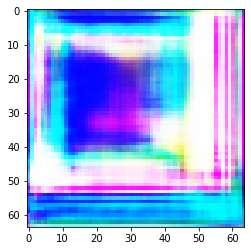

In [35]:
plt.imshow(shift_zero_one(test_image3and[0]))

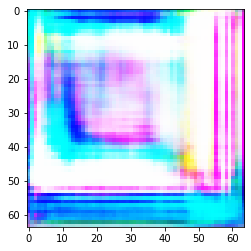

In [36]:
plt.imshow(shift_zero_one(test_image3and[1]))

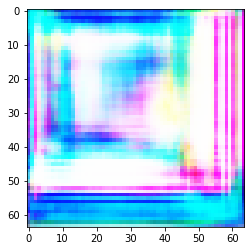

In [37]:
plt.imshow(shift_zero_one(test_image3and[2]))

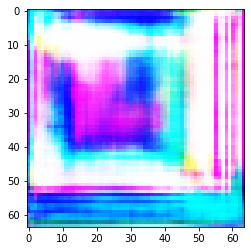

In [38]:
plt.imshow(shift_zero_one(test_image3and[3]))

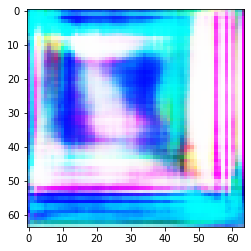

In [39]:
plt.imshow(shift_zero_one(test_image3and[4]))